In [29]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

<h1>
    VQC from Pennylane Tutorial
</h1>

In [24]:
np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [25]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

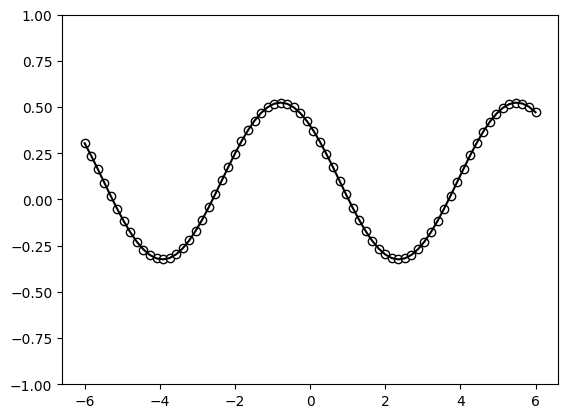

In [26]:
x = np.linspace(-6, 6, 70, requires_grad=False)
# x = np.linspace(-6, 6, 10, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show();

In [27]:
scaling = 1
dev = qml.device('default.qubit', wires=1)

def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0, id="x0")

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev, interface="autograd")
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))


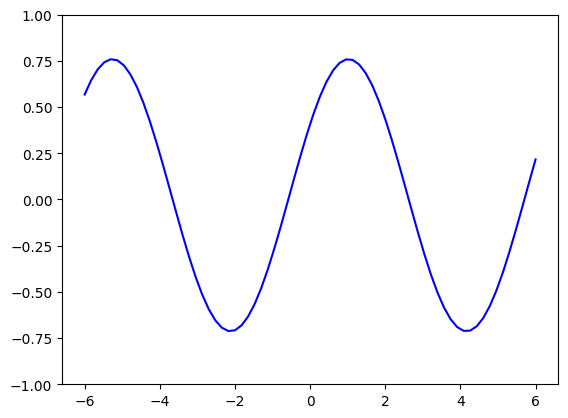

In [28]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
# x = np.linspace(-6, 6, 10, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [29]:
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(2.35,5.97,4.60)──RX(6.00)──Rot(3.76,0.98,0.98)─┤  <Z>


In [30]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.032120417200045624
Cost at step  20: 0.013853561883024756
Cost at step  30: 0.004049396436389454
Cost at step  40: 0.0005624933894468386
Cost at step  50: 8.145777333270847e-05


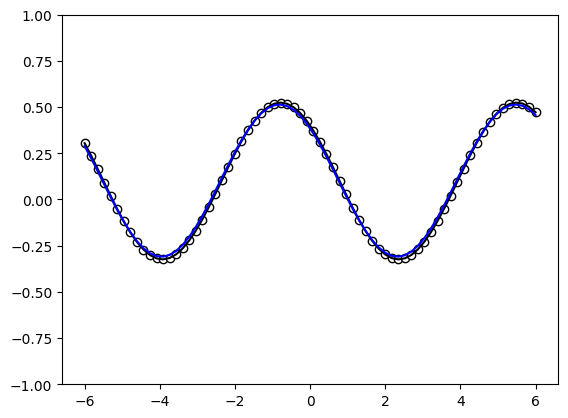

In [31]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

<img src="pics/RFF1-steps.png" width="480" height="240"/>


In [32]:
# Step 2: Use all eigenvalues to obtain the frequencies

<img src="pics/eq4.png" width="480" height="240"/>
<img src="pics/eq5.png" width="480" height="240"/>

In [33]:
freqs = circuit_spectrum(serial_quantum_model)(weights, x)
for k, v in freqs.items():
    print(k, ":", v)

print(freqs)

x0 : [-1.0, 0, 1.0]
{'x0': [-1.0, 0, 1.0]}


In [34]:
# Step 3: Sample D frequencies
D = 3
sampled_freqs = freqs
temp = np.array(D)

In [35]:
'''
for a single x, y pair, the kernel function looks like:
    phi(y).T --> [
                      1/sqrt(D) * cos(omega1.T * y), 1/sqrt(D) * cos(omega2.T * y), 1/sqrt(D) * cos(omega3.T * y),
                      1/sqrt(D) * sin(omega1.T * y), 1/sqrt(D) * sin(omega2.T * y), 1/sqrt(D) * sin(omega3.T * y)                  
                  ]
    
    phi(x)   --> [
                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * cos(omega3.T * x)
                    1/sqrt(D) * sin(omega1.T * x), 1/sqrt(D) * sin(omega2.T * x), 1/sqrt(D) * sin(omega3.T * x)
                  ]
                  
    phi(x).T --> [
                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * sin(omega1.T * x),
                    1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * sin(omega2.T * x),
                    1/sqrt(D) * cos(omega3.T * x), 1/sqrt(D) * sin(omega3.T * x)
                  ]
                  
    k(x, y) = phi(y).T * phi(x).T  --> [something + something]
'''


# Step 4: Construct the approximated kernel
# We think that we don't need to construct a kernel function
# def phi_tilde(x, sampled_freq):
#     empty = np.zeros((D, 2))
#     for i in range(D):
#         empty[i][0] = 1/np.sqrt(D) * np.cos(sampled_freq[i] * x)
#         empty[i][1] = 1/np.sqrt(D) * np.sin(sampled_freq[i] * x)
#     return empty

'\nfor a single x, y pair, the kernel function looks like:\n    phi(y).T --> [\n                      1/sqrt(D) * cos(omega1.T * y), 1/sqrt(D) * cos(omega2.T * y), 1/sqrt(D) * cos(omega3.T * y),\n                      1/sqrt(D) * sin(omega1.T * y), 1/sqrt(D) * sin(omega2.T * y), 1/sqrt(D) * sin(omega3.T * y)                  \n                  ]\n    \n    phi(x)   --> [\n                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * cos(omega3.T * x)\n                    1/sqrt(D) * sin(omega1.T * x), 1/sqrt(D) * sin(omega2.T * x), 1/sqrt(D) * sin(omega3.T * x)\n                  ]\n                  \n    phi(x).T --> [\n                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * sin(omega1.T * x),\n                    1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * sin(omega2.T * x),\n                    1/sqrt(D) * cos(omega3.T * x), 1/sqrt(D) * sin(omega3.T * x)\n                  ]\n                  \n    k(x, y) = phi(y).T * phi(x).T  --> [somethin

<img src="pics/weights.png" width="360" height="240"/>
<img src="pics/phi_x.png" width="480" height="360"/>

In [36]:
# Step 5: Todo - construct linear regression function and solve for w (weights)]

weight



NameError: name 'weight' is not defined

In [ ]:
# def approximate_f(x):
#     return phi_tilde(x)

# for i in range(len(x)):
#     print(approximate_f(x))

<h1>
    VQC from Lecture Demo
</h1>

In [ ]:
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

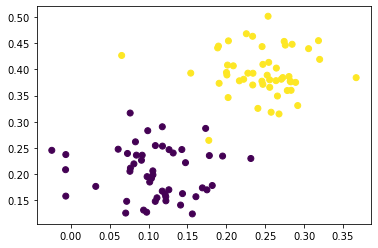

In [ ]:
plot_data(X, y)

In [ ]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1

In [ ]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def model_2(point, weights):
    qml.AngleEmbedding(point, wires=[0, 1])
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliX(0))

In [ ]:
weights = np.random.normal(size=(2, 3), requires_grad=True)
weights

tensor([[0.04327169, 1.03047342, 0.15136947],
        [0.86279699, 0.54466744, 2.01688754]], requires_grad=True)

In [ ]:
print(qml.draw(model_2, expansion_strategy="device")(X[0], weights))

0: ──RX(0.12)──Rot(0.04,1.03,0.15)─╭X─┤  <X>
1: ──RX(0.25)──Rot(0.86,0.54,2.02)─╰●─┤     


In [ ]:
loss = make_loss_function(X, y, model_2)

In [ ]:
# opt = qml.GradientDescentOptimizer(stepsize=0.1)

# n_its = 100

# loss_track = []

# for it in range(n_its):
#     weights, _loss = opt.step_and_cost(loss, weights)
#     if it % 5 == 0:
#         our_preds = make_predictions(X, model_2, weights)
#         print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
#     loss_track.append(_loss)

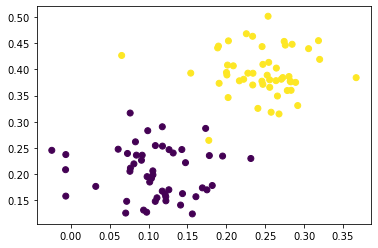

In [ ]:
our_preds = make_predictions(X, model_2, weights)
plot_data(X, y)

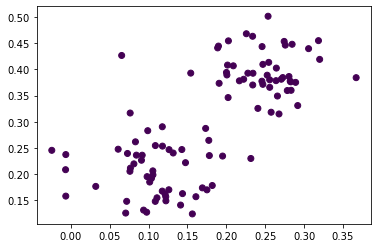

In [ ]:
plot_data(X, our_preds)

In [ ]:
compute_accuracy(our_preds, y)

0.5

<h1>
    Steps
</h1>

<img src="pics/RFF1-steps.png" width="480" height="240"/>


In [ ]:
# print(weights)
# coeffs = weights

In [ ]:
# 1. Diagonalize the Hamiltonians of the above VQC

# obs = [qml.PauliX(0)]
# coeffs = [1]
# H = qml.Hamiltonian(coeffs, obs)

# print(H)

In [ ]:
# w, v = np.linalg.eig(H)

<img src="pics/D_Photo.png" width="1000" height="240"/>


Variables we need to compute for D
1. d (This is the number of qubits) (It's important to note that the number of dimensions in a VQC can also depend on the specific encoding scheme used to encode the input data onto the qubits. For example, if you use the Pauli encoding scheme, where each Pauli operator is applied to a separate qubit to encode a feature, then the number of dimensions in the feature space is equal to the number of Pauli operators used.)
2. C<sub>1</sub>
3. C<sub>2</sub>
4. λ
5. Ω [-L, L]<sup>d</sup>
6. ε
7. L (is the number of Pauli encoding gates on each of the d dimensions and full freedom on the associated frequency coefficients)
8. δ
9. X (This is a compact set R<sup>d</sup>)




In [46]:
#This is the circuit for algo 2

import pennylane as qml
import numpy as np

n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(x, w):
    for l in range(n_layers):
        qml.RX(x[0], wires=0, id="x"+str(0))
        qml.Rot(w[l,0,0], w[l,0,1], w[l,0,2], wires=0)
    qml.RZ(x[0], wires=0, id="x0")
    return qml.expval(qml.PauliZ(wires=0))

x = np.array([1, 2, 3])
w = np.random.random((n_layers, 1, 3))
res = qml.fourier.circuit_spectrum(circuit)(x, w)

print(qml.draw(circuit)(x, w))
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

0: ──RX(1.00)──Rot(0.31,0.20,0.56)──RX(1.00)──Rot(0.21,0.20,0.61)──RZ(1.00)─┤  <Z>
x0: [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0]


In [36]:
n_layers = 2

#The gates are RX but you are trying to diagonalize Paulix and Pauliz
def encoding_eigvals(x):
    rxEigvalOne = qml.eigvals(qml.PauliX(wires=0))/2
    rxEigvalTwo = qml.eigvals(qml.PauliX(wires=0))/2
    rzEigval = qml.eigvals(qml.PauliZ(wires=0))/2
    
    return rxEigvalOne, rxEigvalTwo, rzEigval

x = 1
rxEigvalOne, rxEigvalTwo, rzEigval = encoding_eigvals(x)

#Create an array of all possible combinations of the eigenvalues
upperCaseLambdaArray = []
for eigValOne in rxEigvalOne:
    for eigValTwo in rxEigvalTwo:
        for eigValThree in rzEigval:
            upperCaseLambdaArray.append(eigValOne+eigValTwo+eigValThree)

#Create an array of all possible frequency values stored in OmegaArray
OmegaArray = []
for upperCaseLambdai in upperCaseLambdaArray:
    for upperCaseLambdaj in upperCaseLambdaArray:
        OmegaArray.append(upperCaseLambdai-upperCaseLambdaj)

#Create an new array of unique frequency values stored in OmegaArray
OmegaArray = np.unique(OmegaArray)

print(OmegaArray)

[-3. -2. -1.  0.  1.  2.  3.]


In [45]:
#Helper function to create a range of floats for Algorithm 3
def range_with_floats(start, stop, step):
    while stop >= start:
        yield start
        start += step

#Algorithim 3
#Number of layers
n_layers = 2

#For the circuit we use with each algorithm the number of encoding gates is number of layers + 1
#This is because we have one additional encoding gate RZ.
numberOfEncodingGates = n_layers + 1

#Because the eigenvalues of PauliX and PauliZ gates are -0.5 and 0.5 we know that w_max is numberOfEncodingGates
wMax = numberOfEncodingGates

#We need to assign a step value a resonable step value is anywhere from 0 to 1
step = 1

grid = []

#Create the grid
for i in range_with_floats(0, wMax, step):
    grid.append(i)

print(grid)


[0, 1, 2, 3]


#Construction of Approximation


In [ ]:
def construct_phi(x, frequencies):
  #constructs phi or tilde_phi 
  #based on x and the given frequencies

  phi = np.zeros(2* len(frequencies))
  for i in range(len(frequencies)):
    phi[2*i] = np.cos(frequencies[i] * x)
    phi[2*i+1] = np.sin(frequencies[i] * x)
  
  return phi

def construct_Phi(xi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = np.zeros((M, P))

  for i in range(M):
    phi = construct_phi(xi_array[i], frequencies)
    for j in range(P):
      Phi[i][j] = phi[j]
  return Phi

def construct_w(xi_array, yi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = construct_Phi(xi_array, frequencies)
  lambda_hyper = 0.001

  Phi_T = np.transpose(Phi)

  w_1 = np.matmul(Phi_T, Phi) + M*lambda_hyper * np.identity(P)
  w_2 = np.matmul(np.linalg.inv(w_1), Phi_T)
  w = np.matmul(w_2, yi_array)
  return w

def f(x, w, frequencies):
  phi = construct_phi(x, frequencies)
  return np.matmul(w, phi)